# Notebook demonstrating the use of the pubmetric package

## Imports and installation

You can install the packages needed using the following command `pip install -r setup.py`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import igraph              
import py4cytoscape as p4c # note that Cytoscape has to be installed and open on your machine for visualisation to work
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))

import matplotlib.image as mpimg

import asyncio
import nest_asyncio
nest_asyncio.apply() # Necessary for asyncio notebook compatibility

from wfqc.network import create_citation_network 
from wfqc.workflow import *
from wfqc.metrics import *

## Graph generation

For FastAPI compatibility the main function of the PubMetric package (create_citation_network) needs to be executed within asyncio.run().

### Load data

In [2]:
path_to_data = 'out_202407041439' 

loaded_graph = asyncio.run(create_citation_network(inpath=path_to_data, load_graph=True)) # TODO: if no data then make data or ask if make data?


Graph loaded from out_202407041439
Graph creation complete


### Generate new graph


#### Test size

For example with a smaller testsize 

In [3]:
testsize_graph = asyncio.run(create_citation_network(test_size=20))
print(testsize_graph.vs['name'])


Creating a new doi-pmid library


Writing new doi, pmid pairs to file doi_pmid_library.json
Found 2 more tools with pmid using their doi's


Nr of tools in bio.tools without a publication date: 2
Found 20 out of a total of 1874 tools with PMIDS.


Creating citation graph using igraph.
3290 unique out of 3290 edges total!
Removed 0 self loops and multiples of edges.
Removed 3279 disconnected tools and citations (with degree less or equal to 1) in the 'bipartite' graph.
Number citation of vertices removed with degree threshold 20: 0
Number of remaining tools/vertices is 4, and number of remaining edges are 3
Adding graph attributes.
Saving data to directory outs/out_20240801212546.
Graph creation complete
['37328457', '28394336', '26653327', '36939687']


In [7]:
print(testsize_graph.vs.attributes())
print(testsize_graph.vs['tool_name'])

['name', 'pmid', 'tool_name', 'age', 'nr_citations']
[1, 7, 8, 1]


#### Full network

Or the entire bio.tools database proteomics topic (default), or another specified topic:

In [6]:
graph = asyncio.run(create_citation_network(topic_id="topic_0121")) # this is the default value for topic id, Im writing it for clearity

Found 457 more tools with pmid using their doi's


Nr of tools in bio.tools without a publication date: 320
Found 1832 out of a total of 1874 tools with PMIDS.


Creating citation graph using igraph.
131421 unique out of 131421 edges total!
Removed 0 self loops and multiples of edges.
Removed 83035 disconnected tools and citations (with degree less or equal to 1) in the 'bipartite' graph.
Number of vertices removed with degree threshold 20: 15
Number of remaining tools/vertices is 1229, and number of remaining edges are 31785
Saving data to directory outs/out_20240731175057.


Lets check what attributes the co-citation graph has, and that the it was correctly generated

In [ ]:
graph_attributes = graph.vs.attributes()
print("Graph-level attributes:", graph_attributes)

edge_attributes = graph.es.attributes()
print("Edge-level attributes:", edge_attributes)
print(f"Max edge weight is {max(list(G.es['weight']))}, min edge weight is {min(G.es['weight'])}")

Graph-level attributes: ['name']
Edge-level attributes: ['weight']
Max edge weight is 1986, min edge weight is 1


In [ ]:
degrees = [vs.degree() for vs in graph.vs]
weigths_edges = graph.es['weight']

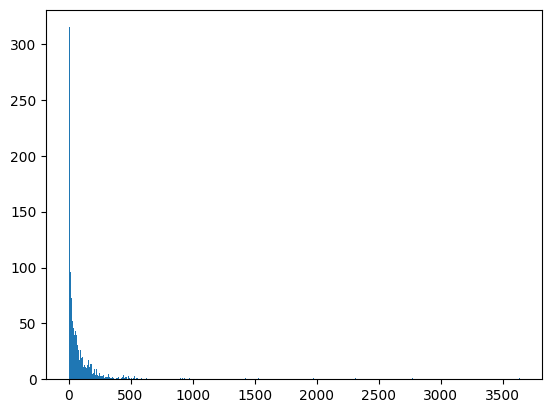

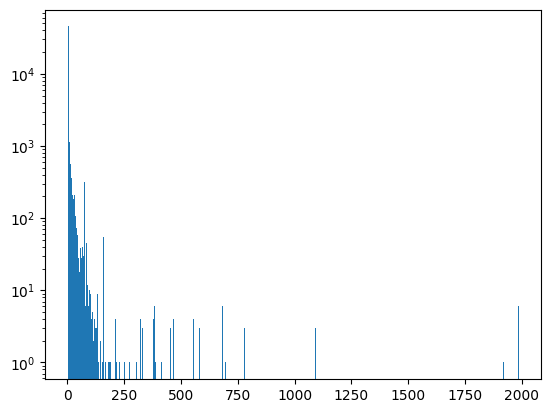

In [ ]:
plt.hist(degrees, bins=500
         )
plt.show()
plt.hist(weigths_edges, bins=500
         )
plt.yscale('log')
plt.show()

In [ ]:
print("median weight:",  np.median(list(graph.es['weight'])))
print("mean weight:",np.mean(list(graph.es['weight'])))

median weight: 1.0
mean weight: 4.582077307589575


## The metric

### Download workflow data


Load the latest bio.tools metadata file and test that loading one workflow works

In [4]:
cwl_file_path = "./workflows/workflomics/candidate_workflow_23.cwl" # loading one of the APE generated workflows 
metadate_file_path = 'out_202407041439/tool_metadata.json'
workflow = parse_cwl_workflows(cwl_file_path, metadate_file_path)

Displaying the workflow which will be in the (TODO: reference workflow schema) workflow schema. Note that json format changes the tuples to lists, but in the original variable workflow "edges" is still a list of tuples

In [8]:
print(json.dumps(workflow, indent=4)) # 

{
    "edges": [
        [
            "XTandem_01",
            "ProteinProphet_02"
        ],
        [
            "ProteinProphet_02",
            "StPeter_04"
        ],
        [
            "XTandem_03",
            "StPeter_04"
        ]
    ],
    "steps": {
        "ProteinProphet_02": "14632076",
        "StPeter_04": "29400476",
        "XTandem_01": "14976030",
        "XTandem_03": "14976030"
    },
    "pmid_edges": [
        [
            "14976030",
            "14632076"
        ],
        [
            "14632076",
            "29400476"
        ],
        [
            "14976030",
            "29400476"
        ]
    ]
}


In [9]:
random_workflow = generate_random_workflow(loaded_graph.vs['name'], workflow['pmid_edges'], random_seed = 42) #TODO change to take into account the repitition of tools - new wf format 

In [10]:
print(json.dumps(random_workflow, indent=4)) 

[
    [
        "38384861",
        "32897718"
    ],
    [
        "32897718",
        "28783153"
    ],
    [
        "38384861",
        "28783153"
    ]
]


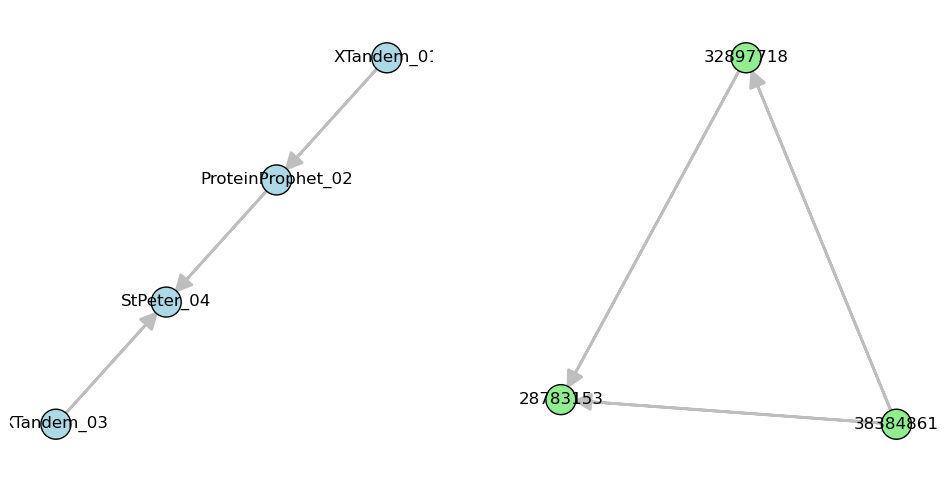

In [15]:
workflow_graph = igraph.Graph.TupleList(edges= workflow['edges'], directed=True)
random_workflow_graph = igraph.Graph.TupleList(edges=random_workflow, directed=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
igraph.plot(workflow_graph, target=ax1, layout=g1.layout("kk"), vertex_label=g1.vs["name"], 
        vertex_color='lightblue', edge_color='gray', vertex_size=30, bbox=(300, 300))
igraph.plot(random_workflow_graph, target=ax2, layout=g2.layout("kk"), vertex_label=g2.vs["name"], 
        vertex_color='lightgreen', edge_color='gray', vertex_size=30, bbox=(300, 300))
plt.show()


We can also show the importance of maintaining the hierchy of the workflow, especially in the case of tool repetitions, to be sure we preserve the context for each tool within the workflow. To do this we plot the workflow where repetitions are not taken into account as well as the workflow where they are.

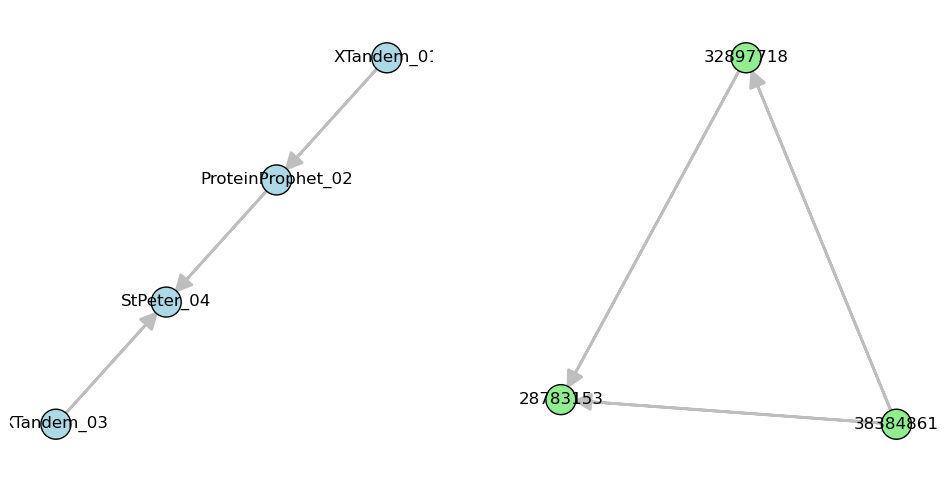

In [16]:

no_repetition_workflow_graph = igraph.Graph.TupleList(edges=workflow['pmid_edges'], directed=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
igraph.plot(workflow_graph, target=ax1, layout=g1.layout("kk"), vertex_label=g1.vs["name"], 
        vertex_color='lightblue', edge_color='gray', vertex_size=30, bbox=(300, 300))

igraph.plot(no_repetition_workflow_graph, target=ax2, layout=g2.layout("kk"), vertex_label=g2.vs["name"], 
        vertex_color='lightgreen', edge_color='gray', vertex_size=30, bbox=(300, 300))
plt.show()


### Calculate metric

Test that calculating a tool level metric for one workflow works

In [17]:
# For the metric based on the average fo the edges within the workflow we dont need to take into account the structure, so we just give the metric the pmid edges
metric_score = workflow_average_sum(loaded_graph, workflow['pmid_edges'])
random_metric_score = workflow_average_sum(loaded_graph, random_workflow)
print(f"The score for the Workflomics generated workflow is {metric_score}")
print(f"The score for the randomly generated workflow with the same structure is {random_metric_score}")


The score for the Workflomics generated workflow is 94.667
The score for the randomly generated workflow with the same structure is 0.0


## Visualisation


Using cytoscape to visualise the network, but as we have seen the vast majority are low degree vertices lets first remove the low degree vertices to make it less computationally heavy 

In [23]:
vertices_to_remove = [v.index for v in loaded_graph.vs if v.degree() < 20]
loaded_graph_small = loaded_graph.copy()
loaded_graph_small.delete_vertices(vertices_to_remove)

original_vertices = len(loaded_graph.vs)
original_edges = len(loaded_graph.es)
new_vertices = len(loaded_graph_small.vs)
new_edges = len(loaded_graph_small.es)

vertex_decrease_percentage = ((original_vertices - new_vertices) / original_vertices) * 100
edge_decrease_percentage = ((original_edges - new_edges) / original_edges) * 100

print(f"Original graph had {original_vertices} vertices and {original_edges} edges, "
      f"the smaller graph has {new_vertices} vertices and {new_edges} edges.")
print(f"Percentage decrease in vertices: {vertex_decrease_percentage:.2f}%")
print(f"Percentage decrease in edges: {edge_decrease_percentage:.2f}%")

Original graph had 1219 vertices and 52414 edges, the smaller graph has 747 vertices and 49447 edges.
Percentage decrease in vertices: 38.72%
Percentage decrease in edges: 5.66%


In [24]:
current_time = datetime.now().strftime("%Y%m%d%H%M")

p4c.create_network_from_igraph(loaded_graph_small, f"Cocitations_{current_time}", collection="Citation networks")


Applying default style...
Applying preferred layout


128

Lets visualise the two workflows in the graph

In [25]:
print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)


Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

In [28]:
# # Styling edges this is too intense
# p4c.set_edge_label_mapping('weight')
# p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('weight', mapping_type='c'))

Showing an image of the graph if you dont have cytoscape

In [ ]:
img = mpimg.imread('...image.png') #TODO: add
plt.imshow(img)
plt.axis('off')  
plt.show()
